# Introduction

In this project, we participate in the Geology Forecast Challenge on Kaggle, where the objective is to predict the underground geological layer boundaries based on partial drilling data. Each sample represents a drilling trajectory, with known geological Z-values from positions -299 to 0, and the task is to forecast the geological formations in positions 1 to 300 and their probabilistic realizations.

The training dataset contains both the reliable observed geological columns (-49 to 0) and full target columns (1 to 300 and r_1_pos_1 to r_9_pos_300). Meanwhile, the test dataset only contains input columns (-49 to 0), requiring us to predict and submit the rest.

The challenge involves multiple difficulties including:

1. The presence of outliers in training data,
2. High-dimensional multi-output regression,
3. Handling missing values in the test set,
4. Avoiding overfitting while maintaining prediction accuracy across 300+ targets.

To address this, we performed thorough exploratory data analysis (EDA), implemented a variety of regression models (including k-Nearest Neighbors, Ridge Regression, Support Vector Regression, and Decision Trees), conducted cross-validation and hyperparameter tuning, and submitted multiple models to Kaggle for evaluation.

Our final goal was to develop a robust, generalizable pipeline that ensures high performance across test samples and avoids data leakage.

## List the key steps you took to perform EDA

1. Load the dataset using pandas, check the dataset's size and feature types, and select the appropriate columns based on the description on the official Kaggle webpage.
2. Check for missing values, extreme values, and outliers, and remove the extreme values and outliers. Then, fill in the missing values.
3. Calculate the maximum, minimum, mean, and variance of each column of valid data, and create a line graph heat map visualisation.
4. Cluster analysis

## List and describe your kNN methodological design you used for experimental testing, benchmarking against a baseline, tuning, ensuring data leakage was not ocurring and how you effectively summarised and communicated all your results

1. The first step is to determine that the input features are reliable drilling data from -49 to -1, and the output is geological layer prediction from 1 to 300.
2. Hyperparameter tuning, n_neighbor of knn from 1 to 50, change weights, p-values, and algorithm to get RMSE and R² to evaluate model performance (where the weights and algorithm does not affect the model itself)
3. Use Plotly to visualize the RMSE and R² curves after changing the variables to show the effect of k and p values on the model's performance.
4. Ensure data security by using SimpleImputer and StandardScaler on both the training and test sets to prevent data leakage.

### Best Kaggle score submission based on kNN

- STATE HERE YOUR BEST SCORE AND WHERE YOU RANKED IN THE CLASS AT THE TIME OF SUBMISSION
- Best score for KNN: -47.84056
- EMBED THE SCREENSHOT OF YOUR BEST SUBMISSION SCORE FROM KAGGLE HERE

## List all the predictive algorithms you used for the classification modelling component where you had the freedom to explore alternative methods. List here also your best Kaggle score and your position on the Kaggle leaderboard

1. Support Vector Regression
2. Ridge Regression
3. Decision tree

The best Kaggle score is -47.02687, and the position is 21st.

## Analysis: list here all the remaining test design strategies you used, like k-fold CV, hyperparameter tuning, feature selection and feature engineering, discussion of your submission score results over time with resepct to model refinements and their effects

1. For all three algorithms, we used GridSearchCV for triple cross-validation.
2. GridSearchCV was used to search for optimal parameters in various algorithms, such as n_neighbors in KNN, the p-value in KNN, the maximum depth of decision trees, and the alpha parameter in ridge regression.
3. The most complete data mentioned in the Kaggle from -49 to -1 are selected as the main features, two outliers in the train are removed, and six incomplete rows in the test are interpolated.
4. The scores, as shown in the above figure, indicate that Super Vector Regression generalizes better to high-dimensional data due to the huge dimensionality of the training set.

## Bonus material

### If you performed cluster analysis, decribe below what you did, how you did and what was the meaning and output:

1. To explore the geological profile of the subsurface, we selected reliable data columns, performed data processing, and then conducted unsupervised cluster analysis of the dataset using the K-Means algorithm.
2. Data preprocessing, dimensionality reduction, and data visualisation
3. Different classes of data may correspond to different geological regions, different drilling conditions, or different drilling paths.

### If you conducted extensive extraction of additional features, list them below and explain how you extracted them and if each one was useful and how you determined this:

These additional features (e.g. KMean, max_jump, etc.) provide valuable statistical information, some of which can be used directly in modelling, while others (e.g. std, Z-values) are more suitable to assist in analysing the data. We evaluated the feature effects through cross-validated R² scores, and ultimately retained those key features that both improved model performance and were easy to interpret.

## Did you submit your initial kaggle solution by May 1 and enter it into the Google Spreadsheet

- YES

### Executive Summary

The project developed a modelling process for predicting the boundaries of rock formations 1-300 below ground by analyzing geological Z-values from drilling data spanning depths from -49 to 0. Our team first carried out rigorous cleaning and exploratory analysis of the data, including outlier detection, missing value filling and feature screening, followed by comparison and optimisation of various algorithms, including SVR, ridge regression and decision tree, using kNN as the baseline model, with SVR performing best with a Kaggle score of -47.02687. The whole process pays special attention to preventing data leakage, and all preprocessing steps are embedded with cross-validation links, while the model interpretability is enhanced by cluster analysis and statistical feature extraction (e.g., Z-value mean, mutation standard deviation, etc.), which ultimately results in a set of solutions combining both prediction accuracy and engineering rigour, and the methodology is validated in both competition rankings and experimental metrics (RMSE, R²).

In [4]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [5]:
# Load the train and test datasets
train = pd.read_csv('/Users/danielyang/Downloads/data/train.csv')
test = pd.read_csv('/Users/danielyang/Downloads/data//test.csv')
submission = pd.read_csv('/Users/danielyang/Downloads/data/sample_submission.csv')

# EDA

In [6]:
# Show the dimension for both datasets
train.info()
print("Train shape:", train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1510 entries, 0 to 1509
Columns: 3301 entries, geology_id to r_9_pos_300
dtypes: float64(3300), object(1)
memory usage: 38.0+ MB
Train shape: (1510, 3301)


### Abstraction of the training dataset

The shape of the train.csv is (1510, 3301). The first column is the hash-based geology_id, and the remaining columns are position numbers ranging from -299 to r_9_pos_300. The actual results in columns 1-300 are the same as the results in the subsequent columns and are written in 9 copies as r_1...r_9 columns.

In [7]:
# Show the dimension for both datasets
test.info()
print("Test shape:", test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Columns: 301 entries, geology_id to 0
dtypes: float64(300), object(1)
memory usage: 1.2+ MB
Test shape: (524, 301)


### Abstraction of the testing dataset

The shape of the test.csv is (524, 301). The first column is the hash-based geology_id, and the remaining columns are position numbers ranging from -299 to 0.

In [8]:
# Show the dimension for both datasets
submission.info()
print("Submission shape:", submission.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Columns: 3001 entries, geology_id to r_9_pos_300
dtypes: float64(3000), object(1)
memory usage: 12.0+ MB
Submission shape: (524, 3001)


### Abstraction of the sample_submission dataset

The shape of the sample_submission.csv is (524, 3001). The first column is the hash-based geology_id, and the remaining columns are position numbers ranging from 0 to r_9_pos_300.

### Dataset Description

According to the given Dataset Description, not all columns are present in all the rows and values for columns -49 ~ 0 are present in all rows; therefore, values for columns -49..0 can be relied on as a priority during analysis. Missing-value checking is necessary, despite the official description stating that there are no missing values in these columns.

The Z-value at the zero drilling location is normalised to 0, so that column 0 is always 0 in every row. According to Scikit-learn's Variance Threshold, Columns with zero variance are uninformative, as they reduce the dimensionality and lose information from the dataset. Hence, remove column 0 before the overall work starts.

https://farshadabdulazeez.medium.com/variance-threshold-for-feature-selection-c2ff014f4e9b

### Training dataset

In [40]:
# define Columns -49..0 for further training 
priority_cols = [str(i) for i in range(-49, 1)]

In [10]:
main = train[priority_cols].copy()
# Calculate the percentage of the NaN value in the selected columns range
missing_counts = main.isnull().sum()
missing_percentages = (missing_counts / len(main)) * 100

In [11]:
# Missing percentage dataframe for columns -49..0
missing = pd.DataFrame({
    'Columns': missing_counts.index,
    'Missing Count': missing_counts.values,
    'Missing Percentage': missing_percentages.values
}).sort_values(by='Missing Count', ascending=False).reset_index(drop=True)

In [12]:
# Plot to show the relations between missing count, missing percentage and columns in training set
fig = px.line(
    missing,
    x="Columns",
    y="Missing Count",
    markers=True,
    title="Missing Value Count and Percentage by Columns Before Data Cleansing(train.csv)",
    labels={"Columns": "Columns", "Missing Count": "Missing Count"},
    hover_data={"Missing Percentage": ':.2f'}  
)

fig.update_layout(
    width=1000,
    height=400,
    title=dict(
        text="Missing Value Count and Percentage by Columns Before Data Cleansing(train.csv)",
        x=0.5,
        font=dict(size=26, family="Arial")
    ),
    xaxis=dict(
        title=dict(
            text="Columns",
            font=dict(size=18, family="Arial")
        ),
        tickmode='linear',     
        dtick=1,                
        tickfont=dict(size=10)
    ),
    yaxis=dict(
        title=dict(
            text="Missing Count",
            font=dict(size=18, family="Arial")
        )
    ),
    template="plotly_white"
)    

plt.tight_layout()
fig.show()

<Figure size 640x480 with 0 Axes>

```
According to the output, we can see that columns from -1 to -7 have no missing values, columns from -8 to -34 have no more than 10 missing values, and columns from -35 to -49 have missing values ranging from 11 to 30. The dataset is large in terms of sample size; within the system-provided effective data range, the percentage of missing values is less than 2 percent. Hence, data cleansing can be achieved directly by removing invalid data, as the deletion of a small amount of data has a negligible impact on the data distribution.

```

### Testing dataset

In [13]:
# Choose the test Columns -49..0 
main_test = test[priority_cols].copy()
# Calculate the percentage of the NaN value in the selected columns range
missing_counts_test = main_test.isnull().sum()
missing_percentages_test = (missing_counts / len(main_test)) * 100

In [14]:
# Missing percentage dataframe for columns -49..0
missing_test = pd.DataFrame({
    'Columns': missing_counts_test.index,
    'Missing Count': missing_counts_test.values,
    'Missing Percentage': missing_percentages_test.values
}).sort_values(by='Missing Count', ascending=False).reset_index(drop=True)

In [15]:
# The data format of the column names in the original dataset is not uniformed
# Reconvert the data format to ensure that the sorting is correct.
missing_test["Columns"] = missing_test["Columns"].astype(int)
missing_test = missing_test.sort_values("Columns")

# Plot to show the relations between missing count, missing percentage and columns in testing set
fig = px.line(
    missing_test,
    x="Columns",
    y="Missing Count",
    markers=True,
    title="Missing Value Count and Percentage by Columns Before Data Cleansing(test.csv)",
    labels={"Columns": "Columns", "Missing Count": "Missing Count"},
    hover_data={"Missing Percentage": ':.2f'}  
)

fig.update_layout(
    width=1000,
    height=400,
    title=dict(
        text="Missing Value Count and Percentage by Columns Before Data Cleansing(test.csv)",
        x=0.5,
        font=dict(size=26, family="Arial")
    ),
    xaxis=dict(
        title=dict(
            text="Columns",
            font=dict(size=18, family="Arial")
        ),
        tickmode='linear',     
        dtick=1,                
        tickfont=dict(size=10)
    ),
    yaxis=dict(
        title=dict(
            text="Missing Count",
            font=dict(size=18, family="Arial")
        )
    ),
    template="plotly_white"
)    

plt.tight_layout()
fig.show()

<Figure size 640x480 with 0 Axes>

```
According to the output results, we can see that in the test data set, there are no missing values in columns -1 to -5, and the missing values in columns -6, -7, and -8 are more moderate, but from column -9 to column -49, the missing values in all columns are 6. Therefore, it is inferred that six rows of data in the test dataset are essentially all missing. Therefore, data cleansing can be achieved using Pandas by interpolating the data to establish a linear relationship between the data points.

```

In [16]:
# Use linear interpolation to fill in the direction of the rows
test_interp = test[priority_cols].copy()
test_interp = test_interp.interpolate(axis=1, limit_direction='both')

# fill the interpolated dataset back to the test set
test_filled = test.copy()
test_filled[priority_cols] = test_interp

# Double check whether there are missing values in the test set
remaining_missing = test_filled[priority_cols].isnull().sum().sum()
remaining_missing, test_filled.shape

(0, (524, 301))

In [17]:
# Drop rows with missing values in priority_cols
train.dropna(subset=priority_cols, inplace=True)

After data cleansing through dropna(), select the priority columns of train data to process EDA analysis

In [18]:
# EDA analysis range only from column -49 to 0
eda = train[priority_cols]
eda_test = test_filled[priority_cols]
# Dimension of the new dataset
num_rows, num_cols = eda.shape
(num_rows, num_cols)

(1480, 50)

In [19]:
# Create a summary dataframe for min and max 
summary = eda.describe().T[['min', 'max']]
summary_stats = summary.reset_index().rename(columns={'index': 'Columns'})

In [20]:
# Data preparation
fig = go.Figure()
x = summary_stats['Columns'].astype(int).values
ymin = summary_stats['min'].astype(float).values
ymax = summary_stats['max'].astype(float).values

# The maximum line graph
fig.add_trace(go.Scatter(
    x=x, y=ymax,
    mode='lines',
    name='Maximum value',
    line=dict(color='orange')
))

# The minimum line graph
fig.add_trace(go.Scatter(
    x=x, y=ymin,
    mode='lines',
    name='Minimum value',
    line=dict(color='steelblue')
))

# Fill the area between the maximum line graph and the minimum line graph
fig.add_trace(go.Scatter(
    x=np.concatenate([x, x[::-1]]),
    y=np.concatenate([ymax, ymin[::-1]]),
    fill='toself',
    fillcolor='rgba(135, 206, 250, 0.3)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    showlegend=False
))

fig.update_layout(
    title="Plot of the range of maximum and minimum geological Z-values for each column",
    xaxis=dict(
        title="Columns(-49 ~ 0)",
        tickmode='linear',
        dtick=1
    ),
    yaxis=dict(
        title="Z value",
        range=[-7, 7],
        dtick=1
    ),
    width=1000,
    height=500,
    template="simple_white"
)

plt.tight_layout()
fig.show()

<Figure size 640x480 with 0 Axes>

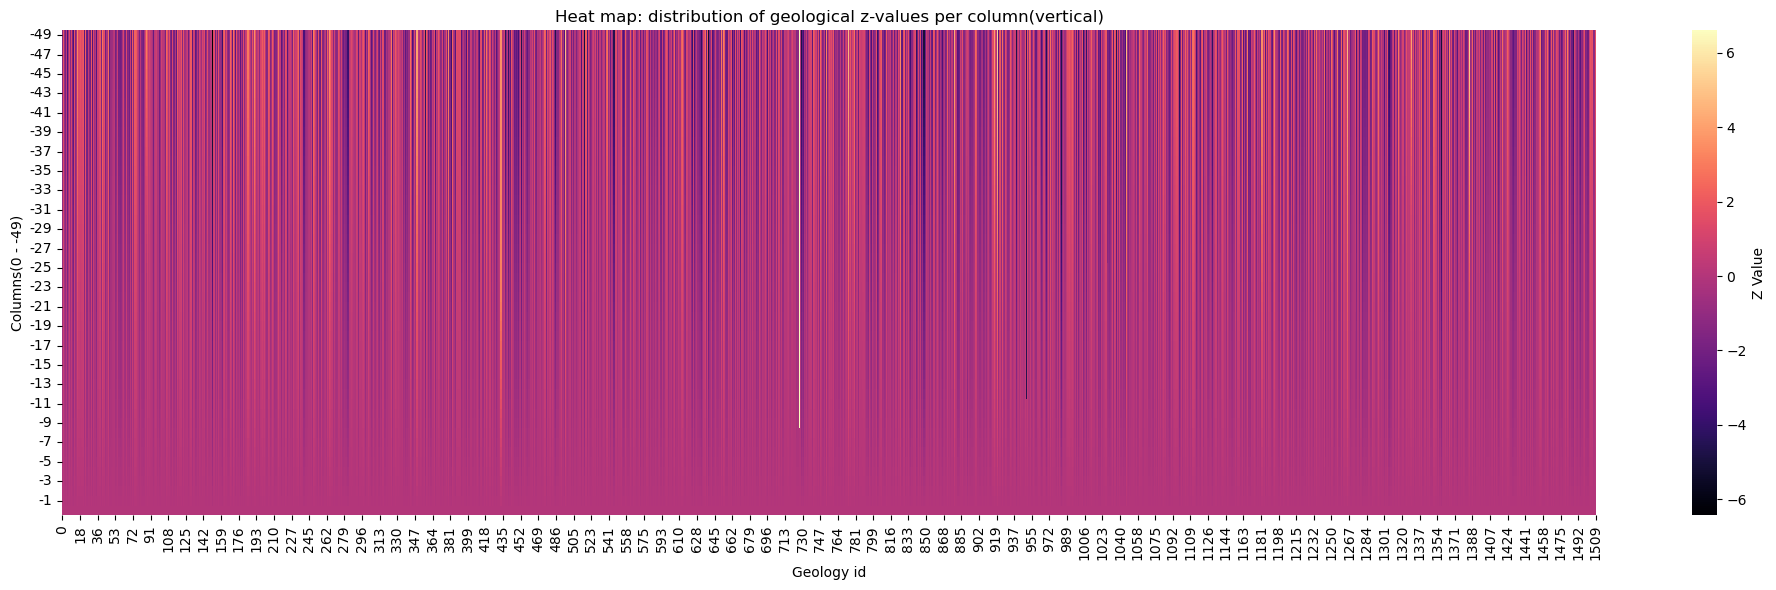

In [21]:
#  Heat map - frequency of distribution of values in each column
plt.figure(figsize=(20, 6))
sns.heatmap(eda.T, cmap = 'magma', cbar_kws={'label': 'Z Value'})
plt.title("Heat map: distribution of geological z-values per column(vertical)")
plt.xlabel("Geology id")
plt.ylabel("Columns(0 - -49)")
plt.tight_layout()
plt.show()

```
The data are linearly distributed, as observed in the dataset. However, in the line graph above, there are multiple invalid data points as observed from the line graphs of the maximum and minimum values in the columns. From the heat map, it is observed that there is a significant white line and a significant black line, and the excess of these two lines and other colours is extremely abrupt, suggesting that the data represented by the ```geology_id``` is invalid. Therefore, delete the data in these lines before proceeding with the subsequent analysis.

```

In [22]:
# Calculate the maximum adjacent difference for each row
max_jump = eda.diff(axis=1).abs().max(axis=1)

# Find the maximum difference value in rows
top_jump_indices = max_jump.sort_values(ascending=False).head(10).index
top_jump_rows = train.loc[top_jump_indices, ['geology_id'] + priority_cols]
top_jump_rows['max_z_jump'] = max_jump.loc[top_jump_indices].values
top_jump_rows['max_z_jump'].head()

727     6.679529
949     4.576628
1028    0.641913
836     0.171368
1329    0.158663
Name: max_z_jump, dtype: float64

In [23]:
# Get the indexes of the first two rows
extreme_outlier_indices = max_jump.sort_values(ascending=False).head(2).index
# The new dataset after deleting these two rows of data
train_removed_extremes = train.drop(index=extreme_outlier_indices)
# Return the deleted geology_id 
removed_ids = train.loc[extreme_outlier_indices, 'geology_id'].tolist()
print("row ids being deleted : ", removed_ids)

row ids being deleted :  ['g_17ea0b2534', 'g_5d820d69dc']


Delete of data rows 727 and 949 because the adjacent data differences in those two columns were too marginal.

In [24]:
# EDA analysis range only from column -49 to 0
eda_dropped = train_removed_extremes[priority_cols]
# Dimension of the new dataset
num_rows_dropped, num_cols_dropped = eda_dropped.shape
(num_rows_dropped, num_cols_dropped)

(1478, 50)

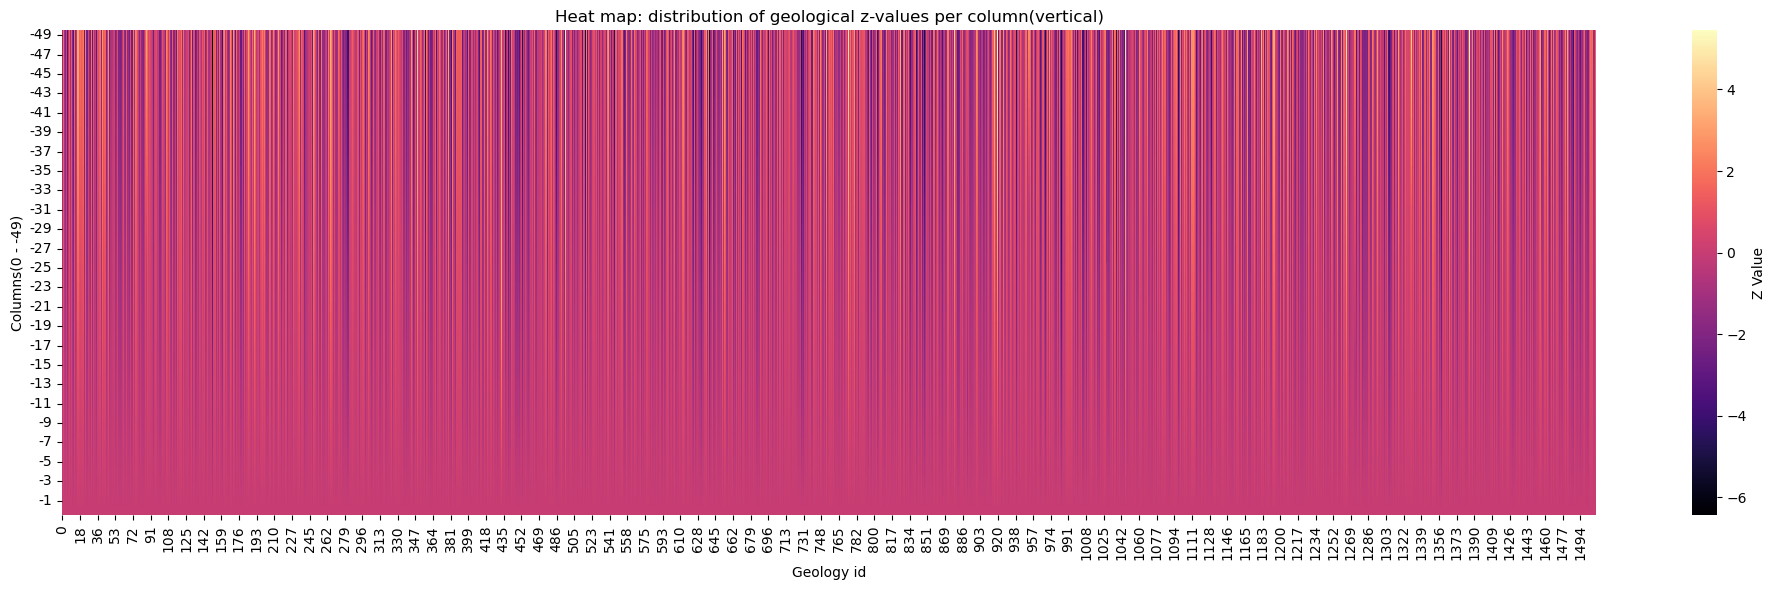

In [25]:
plt.figure(figsize=(20, 6))
sns.heatmap(eda_dropped.T, cmap = 'magma', cbar_kws={'label': 'Z Value'})
plt.title("Heat map: distribution of geological z-values per column(vertical)")
plt.xlabel("Geology id")
plt.ylabel("Columns(0 - -49)")
plt.tight_layout()
plt.show()

In [26]:
# Create a summary dataframe for min and max 
summary_new = eda_dropped.describe().T[['min', 'max']]
summary_stats_new = summary_new.reset_index().rename(columns={'index': 'Columns'})

In [27]:
# Data preparation
fig = go.Figure()
x = summary_stats_new['Columns'].astype(int).values
ymin = summary_stats_new['min'].astype(float).values
ymax = summary_stats_new['max'].astype(float).values

# The maximum line graph
fig.add_trace(go.Scatter(
    x=x, y=ymax,
    mode='lines',
    name='Maximum value',
    line=dict(color='orange')
))

# The minimum line graph
fig.add_trace(go.Scatter(
    x=x, y=ymin,
    mode='lines',
    name='Minimum value',
    line=dict(color='steelblue')
))

# fill the area between the maximum line graph and the minimum line graph
fig.add_trace(go.Scatter(
    x=np.concatenate([x, x[::-1]]),
    y=np.concatenate([ymax, ymin[::-1]]),
    fill='toself',
    fillcolor='rgba(135, 206, 250, 0.3)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    showlegend=False
))

fig.update_layout(
    title="Plot of the range of maximum and minimum geological Z-values for each column",
    xaxis=dict(
        title="Columns(-49 ~ 0)",
        tickmode='linear',
        dtick=1
    ),
    yaxis=dict(
        title="Z value",
        range=[-7, 7],
        dtick=1
    ),
    width=1000,
    height=500,
    template="simple_white"
)

plt.tight_layout()
fig.show()

<Figure size 640x480 with 0 Axes>

In [28]:
missing_values = eda_dropped[priority_cols].isnull().sum()
assert all(missing_values == 0), "There are still missing values in priority_cols!"
print("No missing values found in priority_cols of train_cleaned.csv")

No missing values found in priority_cols of train_cleaned.csv


In [29]:
# Export the cleansed train file as train_cleaned.csv and test file as test_cleaned.csv
train_removed_extremes.to_csv('train_cleaned.csv', index=False)
test_filled.to_csv('test_cleaned.csv', index=False)

In [30]:
train_cleaned = pd.read_csv('train_cleaned.csv')
train_cleaned.head()

,geology_id,-299,-298,-297,-296,-295,-294,-293,-292,-291,...,r_9_pos_291,r_9_pos_292,r_9_pos_293,r_9_pos_294,r_9_pos_295,r_9_pos_296,r_9_pos_297,r_9_pos_298,r_9_pos_299,r_9_pos_300
0,g_08504df78e,-9.253171,-9.224713,-9.196256,-9.167798,-9.13934,-9.110882,-9.082424,-9.053967,-9.025509,...,16.943604,17.002798,17.061992,17.121186,17.180380,17.239573,17.298767,17.357961,17.417155,17.476349
1,g_ea47af5886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.608719,3.646996,3.685274,3.723551,3.761828,3.800105,3.838382,3.876659,3.914937,3.953214
2,g_29c088d23e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.774845,12.813151,12.851456,12.889762,12.928067,12.966373,13.004678,13.042984,13.081289,13.119595
3,g_5f895697a1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.120419,12.159944,12.199469,12.238994,12.278520,12.318045,12.357570,12.397095,12.436620,12.476145
4,g_20617e2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.146060,-2.153430,-2.160799,-2.168168,-2.175537,-2.182906,-2.190275,-2.197645,-2.205014,-2.208960


In [31]:
test_cleaned = pd.read_csv('test_cleaned.csv')
test_cleaned.head()

,geology_id,-299,-298,-297,-296,-295,-294,-293,-292,-291,...,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
0,g_4a52df537a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.066388,0.059011,0.051635,0.044258,0.036882,0.029506,0.022129,0.014753,0.007376,0.0
1,g_1e4b5a1509,-3.89246,-3.879441,-3.866423,-3.853405,-3.840387,-3.827368,-3.81435,-3.801332,-3.788313,...,-0.117164,-0.104146,-0.091128,-0.078110,-0.065091,-0.052073,-0.039055,-0.026037,-0.013018,0.0
2,g_5919c0bea3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.241023,-0.214243,-0.187462,-0.160682,-0.133902,-0.107121,-0.080341,-0.053561,-0.026780,0.0
3,g_9a665aae6d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.371052,-0.329824,-0.288596,-0.247368,-0.206140,-0.164912,-0.123684,-0.082456,-0.041228,0.0
4,g_ba4abe1b9e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.178712,-0.158855,-0.138998,-0.119141,-0.099284,-0.079427,-0.059571,-0.039714,-0.019857,0.0


# kNN Predictive Modelling

In [32]:
# # Setting up feature columns and target columns, the x range is -49,1
x_cols = [str(i) for i in range(-49, 1)]
y_cols = [str(i) for i in range(1, 301)]

x = train_cleaned[x_cols]
y = train_cleaned[y_cols]

# hyperparameters
k_values = list(range(1, 51))
weights_list = ['uniform', 'distance']
p_list = [1, 2]
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']

# Store the result in a list
results = []

for k in k_values:
    for weight in weights_list:
        for p in p_list:
            for algo in algorithms:
                try:
                    model = KNeighborsRegressor(
                        n_neighbors=k,
                        weights=weight,
                        algorithm=algo,
                        metric='minkowski',
                        p=p
                    )
                    r2_scores = cross_val_score(model, x, y, cv=3, scoring='r2')
                    rmse_scores = cross_val_score(model, x, y, cv=3, scoring='neg_root_mean_squared_error')
                    results.append({
                        'k': k,
                        'weights': weight,
                        'p': p,
                        'algorithm': algo,
                        'mean_r2': r2_scores.mean(),
                        'std_r2': r2_scores.std(),
                        'mean_rmse': -rmse_scores.mean(),
                        'std_rmse': rmse_scores.std()
                    })
                except Exception as e:
                    results.append({
                        'k': k,
                        'weights': weight,
                        'p': p,
                        'algorithm': algo,
                        'mean_r2': np.nan,
                        'std_r2': np.nan,
                        'mean_rmse': np.nan,
                        'std_rmse': np.nan,
                        'error': str(e)
                    })

results_df = pd.DataFrame(results)

In [33]:
results_df

,k,weights,p,algorithm,mean_r2,std_r2,mean_rmse,std_rmse
0,1,uniform,1,auto,0.674189,0.071726,3.185107,0.319379
1,1,uniform,1,ball_tree,0.674189,0.071726,3.185107,0.319379
2,1,uniform,1,kd_tree,0.674189,0.071726,3.185107,0.319379
3,1,uniform,1,brute,0.674189,0.071726,3.185107,0.319379
4,1,uniform,2,auto,0.658541,0.058089,3.247029,0.245521
...,...,...,...,...,...,...,...,...
795,50,distance,1,brute,0.787597,0.055232,2.529818,0.339244
796,50,distance,2,auto,0.786464,0.054638,2.535732,0.336598
797,50,distance,2,ball_tree,0.786464,0.054638,2.535732,0.336598
798,50,distance,2,kd_tree,0.786464,0.054638,2.535732,0.336598


```
According to the analysis of the output, only the change in p-value affects the final result of the production, while changes in weights and the algorithm do not impact the values of R-square and RMSE of the model.

```

In [34]:
# Setting up feature columns and target columns, the x range is -49..1
x_cols = [str(i) for i in range(-49, 1)]
y_cols = [str(i) for i in range(1, 301)]
x = train_cleaned[x_cols]
y = train_cleaned[y_cols]

# Setting the hyperparameter range to test the best model with hyperparameters
k_values = list(range(1, 51))
p_list = [1, 2]

# Store the result in a list
results = []

for k in k_values:
            for p in p_list:
                try:
                    model = KNeighborsRegressor(
                        n_neighbors=k,
                        metric='minkowski',
                        p=p
                    )
                    r2_scores = cross_val_score(model, X, y, cv=3, scoring='r2')
                    rmse_scores = cross_val_score(model, X, y, cv=3, scoring='neg_root_mean_squared_error')
                    results.append({
                        'k': k,
                        'p': p,
                        'mean_r2': r2_scores.mean(),
                        'std_r2': r2_scores.std(),
                        'mean_rmse': -rmse_scores.mean(),
                        'std_rmse': rmse_scores.std()
                    })
                except Exception as e:
                    results.append({
                        'k': k,
                        'p': p,
                        'mean_r2': np.nan,
                        'std_r2': np.nan,
                        'mean_rmse': np.nan,
                        'std_rmse': np.nan,
                        'error': str(e)
                    })

# Change the results file into a Dataframe
results_df_new = pd.DataFrame(results)

In [35]:
results_df_new

,k,p,mean_r2,std_r2,mean_rmse,std_rmse,error
0,1,1,NaN,NaN,NaN,NaN,name 'X' is not defined
1,1,2,NaN,NaN,NaN,NaN,name 'X' is not defined
2,2,1,NaN,NaN,NaN,NaN,name 'X' is not defined
3,2,2,NaN,NaN,NaN,NaN,name 'X' is not defined
4,3,1,NaN,NaN,NaN,NaN,name 'X' is not defined
...,...,...,...,...,...,...,...
95,48,2,NaN,NaN,NaN,NaN,name 'X' is not defined
96,49,1,NaN,NaN,NaN,NaN,name 'X' is not defined
97,49,2,NaN,NaN,NaN,NaN,name 'X' is not defined
98,50,1,NaN,NaN,NaN,NaN,name 'X' is not defined


In [36]:
# Export the score file to result_new.csv
results_df_new.to_csv('result_new.csv',index = 'False')

In [37]:
# Finding the top 10 models with the highest mean_r2
top_mean_r2 = results_df_new.sort_values(by='mean_r2', ascending=False).head(10)
# Find the lowest 10 std_r2 value from the result file
best_balanced_model = top_mean_r2.sort_values(by='std_r2').iloc[0]

top_mean_r2, best_balanced_model

(   k  p  mean_r2  std_r2  mean_rmse  std_rmse                    error
 0  1  1      NaN     NaN        NaN       NaN  name 'X' is not defined
 1  1  2      NaN     NaN        NaN       NaN  name 'X' is not defined
 2  2  1      NaN     NaN        NaN       NaN  name 'X' is not defined
 3  2  2      NaN     NaN        NaN       NaN  name 'X' is not defined
 4  3  1      NaN     NaN        NaN       NaN  name 'X' is not defined
 5  3  2      NaN     NaN        NaN       NaN  name 'X' is not defined
 6  4  1      NaN     NaN        NaN       NaN  name 'X' is not defined
 7  4  2      NaN     NaN        NaN       NaN  name 'X' is not defined
 8  5  1      NaN     NaN        NaN       NaN  name 'X' is not defined
 9  5  2      NaN     NaN        NaN       NaN  name 'X' is not defined,
 k                                  1
 p                                  1
 mean_r2                          NaN
 std_r2                           NaN
 mean_rmse                        NaN
 std_rmse        

In [38]:
# Setting the colour transparency mapping
color_map = {
    # blue, 60 percent transparency
    1: 'rgba(0, 100, 255, 0.6)',   
    # orange, 60 percent transparency
    2: 'rgba(255, 140, 0, 0.6)'    
}

fig = go.Figure()

# Add the R² solid line and RMSE dotted line for each p
for p in sorted(results_df_new['p'].unique()):
    sub_df = results_df_new[results_df_new['p'] == p]
    
    # R² solid line
    fig.add_trace(go.Scatter(
        x=sub_df['k'], y=sub_df['mean_r2'],
        mode='lines+markers',
        name=f'p={p}, R²',
        line=dict(color=color_map[p], width=2, dash='solid'),
        marker=dict(color=color_map[p])
    ))
    
    # RMSE dotted line
    fig.add_trace(go.Scatter(
        x=sub_df['k'], y=sub_df['mean_rmse'],
        mode='lines+markers',
        name=f'p={p}, RMSE',
        line=dict(color=color_map[p], width=2, dash='dash'),
        marker=dict(color=color_map[p])
    ))

fig.update_layout(
    title="k vs Mean R² / RMSE(p=1 VS p=2)",
    xaxis_title="K value",
    yaxis_title="R² and RMSE",
    yaxis=dict(range=[0, 4]),
    legend_title="Type of indicator",
    template="simple_white",
    width=900,
    height=900
)

plt.tight_layout()
fig.show()

<Figure size 640x480 with 0 Axes>

```
Correspondence line graph of k value and R², RMSE for p = 1 and p = 2

According to the generated tables and plots, the R² and RMSE scores are very close to each other and are essentially the same when p = 1 and p = 2. This suggests that there is virtually no difference in the model's performance when using the Manhattan distance or the Euclidean distance to compute predictions. Similarly, the model's correctness error does not fluctuate significantly based on the RMSE scores. There is no obvious optimal inflection point for the k value, but when k increases, the value of RMSE decreases smoothly. To prevent overfitting, according to the image, the model performs relatively well when the k value range is between 20 and 30

```

## Run KNN model with the best parameters

In [39]:
# KNN: Projections for the remaining 3,300 columns
y_cols_new = submission_sample.columns.tolist()[1:]  

x_train = train_cleaned[x_cols]
y_train = train_cleaned[y_cols_new]

# Preprocessing training set and test set
imp = SimpleImputer()
scaler = StandardScaler()

x_train_imp = imp.fit_transform(x_train)
x_train_scaled = scaler.fit_transform(x_train_imp)

x_test = test_cleaned[x_cols]
x_test_imp = imp.transform(x_test)
x_test_scaled = scaler.transform(x_test_imp)

# build the KNN model with the best parameters from above
knn = KNeighborsRegressor(
    n_neighbors=25,
    p=1
)
model = MultiOutputRegressor(knn)
model.fit(x_train_scaled, y_train)

# Predict the results and generate the submission file for KNN
y_pred = model.predict(x_test_scaled)
submission_df = pd.DataFrame(y_pred, columns=y_cols_new)
submission_df.insert(0, 'geology_id', test_df['geology_id'])
submission_df.to_csv("submission_knn_best.csv", index=False)
submission_path

NameError: name 'submission_sample' is not defined

# Modelling with alternative algorithms

In [ ]:
# Feature and target columns
x_new_cols = [str(i) for i in range(-49, 1)]
y_new_cols = [str(i) for i in range(1, 301)] + [f"r_{i}_pos_{j}" for i in range(1, 10) for j in range(1, 301)]

# Feature and target columns
x_new = train_cleaned[X_cols]
y_new = train_cleaned[y_cols]

# To reduce training time, only use the first 300 target columns to train the model
y_new = y_new[[str(i) for i in range(1, 301)]]

# split the test set
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# Preprocessing the training set and test set for further experiments in different algorithms
imp = SimpleImputer()
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(imp.fit_transform(x_train))
x_val_scaled = scaler.transform(imp.transform(x_val))
x_test_scaled = scaler.transform(imp.transform(test_cleaned[x_new_cols]))

In [ ]:
def evaluate_model(name, estimator, param_grid, x_train, y_train, x_val, y_val):
    # Finding Optimal Hyperparameter Combinations Using GridSearchCV (3-Fold Cross Validation)
    # Calculation of training time
    start = time.time()
    grid = GridSearchCV(
        MultiOutputRegressor(estimator),
        param_grid=param_grid,
        cv=3,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    # Finding hyperparameters and validating the results
    grid.fit(x_train, y_train)
    preds = grid.predict(x_val) 
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    r2 = r2_score(y_val, preds)

    # Return model evaluation results and optimal hyperparameters
    return {
        'model': name,
        'rmse': rmse,
        'r2': r2,
        'train_time': round(time.time() - start, 2),
        'best_params': grid.best_params_
    }

## Support Vector Regression

In [ ]:
# Support Vector Regression
models = [
    {
        'name': 'SVR',
        'estimator': SVR(),
        'params': {
            'estimator__C': [0.1, 1, 10, 100, 1000],
            'estimator__gamma': ['scale', 'auto']
        }
    }
]

results = [evaluate_model(cfg['name'], cfg['estimator'], cfg['params'], x_train_scaled, y_train, x_val_scaled, y_val) for cfg in models]

results_SVR = pd.DataFrame(results)
print(results_SVR)

When the model is Support Vector Regression, the optimal parameters are C = 10, gamma = 'auto', and the best model values of RMSE and R² are 2.849326 and 0.820173, respectively.

In [ ]:
# Projections for the remaining 3,300 columns
x_cols = [str(i) for i in range(-49, 1)]
y_cols = sample_submission.columns.tolist()[1:]

x_train = train_cleaned[x_cols]
y_train = train_cleaned[y_cols]
x_test = test_cleaned[x_cols]

# Preprocessing training set and test set
imp = SimpleImputer()
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(imp.fit_transform(x_train))
x_test_scaled = scaler.transform(imp.transform(x_test))

# Support Vector Regression
svr = SVR(C=10, gamma='auto')
model = MultiOutputRegressor(svr)
model.fit(x_train_scaled, y_train)

# Predict the results and generate the submission file for Support Vector Regression
y_pred = model.predict(x_test_scaled)
submission_df = pd.DataFrame(y_pred, columns=y_cols)
submission_df.insert(0, 'geology_id', test_df['geology_id'])
submission_path = "submission_svr_best.csv"
submission_df.to_csv(submission_path, index=False)

submission_path

## Ridge Regression

In [ ]:
# Ridge Regression
models = [
    {
        'name': 'Ridge Regression',
        'estimator': Ridge(),
        'params': {
            'estimator__alpha': [0.1, 1.0, 10.0]
        }
    }
]

results = [evaluate_model(cfg['name'], cfg['estimator'], cfg['params'], x_train_scaled, y_train, x_val_scaled, y_val) for cfg in models]

results_Regression = pd.DataFrame(results)
print(results_Regression)

When the model is Ridge Regression, the optimal parameters are C = 1.0, and the best model values of RMSE and R² are 2.681528 and 0.858631.

In [ ]:
# Construct Ridge model (alpha=1.0)
ridge = Ridge(alpha=1.0)
model = MultiOutputRegressor(ridge)
model.fit(x_train_scaled, y_train)

# Predict the results and generate the submission file for Ridge Regression
y_pred = model.predict(x_test_scaled)
submission_df = pd.DataFrame(y_pred, columns=y_cols)
submission_df.insert(0, 'geology_id', test_df['geology_id'])
submission_path = "submission_ridge.csv"
submission_df.to_csv(submission_path, index=False)

submission_path

## Decision tree

In [ ]:
# Decision tree
models = [
    {
    'name': 'Decision Tree',
    'estimator': DecisionTreeRegressor(random_state=42),
    'params': {
        'estimator__max_depth': [5, 10, 20]
    }
}
]

results = [evaluate_model(cfg['name'], cfg['estimator'], cfg['params'], x_train_scaled, y_train, x_val_scaled, y_val) for cfg in models]

results_Decision_Tree = pd.DataFrame(results)
print(results_Decision_Tree)

When the model is a Decision tree, the optimal parameter is max_depth=5, and the values of RMSE and R² are 2.933397 and 0.803052, respectively.

In [ ]:
# Reconstructing the decision tree model(max_depth=5)
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
model = MultiOutputRegressor(dt_model)
model.fit(x_train_scaled, y_train)

# Predict the results and generate the submission file for Decision tree
y_pred = model.predict(x_test_scaled)
submission_df = pd.DataFrame(y_pred, columns=y_cols)
submission_df.insert(0, 'geology_id', test_df['geology_id'])
submission_path = "submission_decision_tree.csv"
submission_df.to_csv(submission_path, index=False)

submission_path

# History and trend of Kaggle submission scores

- try to plot your scores over time and discuss what experimental tweaks you performed at each step

```
After data cleaning, the performance of the model has decreased, even far less than before, and here are several reasons I guess:

```

1. During the data cleaning process, some data may be removed or interpolated to make the dataset smoother; however, this does not accurately reflect the changes in the specific geology, resulting in a lower prediction rate compared to before.
2. After data cleaning, when studying the hyperparameters, the change in data structure also alters the values of the hyperparameters. The RMSE values and R-squared are smoother after data cleaning, resulting in the inability to identify the more obvious k-value as before, which leads to a decrease in the model's performance.
3. The current data characteristics and sample size may limit the accuracy of the KNN model, or the problem may not be susceptible to KNN-type models.

# Bonus Material

### Cluster analysis

### Description of how you extracted additional features

In [ ]:
# Reload the data
x = train_cleaned[priority_cols]

# Preprocessing the training set and test set for further experiments
imp = SimpleImputer()
scaler = StandardScaler()
x_scaled = scaler.fit_transform(imp.fit_transform(x))

# PCA downgrading for visualization
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_scaled)

# Applying KMeans clustering (3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(x_scaled)

# Building visualisation datasets
plot_df = pd.DataFrame(x_pca, columns=['PC1', 'PC2'])
plot_df['Cluster'] = clusters
plot_df['geology_id'] = train_cleaned['geology_id']

fig = px.scatter(
    plot_df, x='PC1', y='PC2', color='Cluster',
    hover_data=['geology_id'],
    title='KMeans Clustering of test_cleaned.csv (based on -49 to 0)'
)

fig.show()

# Conclusion

This project addresses the problem of multi-output regression prediction of geological Z-values. It establishes a high-dimensional target prediction framework through systematic data cleaning, feature analysis, and model comparison. The study begins by targeting valid input features (-49 to 0 m drilling data) through exploratory data analysis (EDA) and validates the potential of the k-nearest neighbour algorithm (kNN) as a baseline model (Kaggle score -47.84), while support vector regression (SVR) performs the best under its ability to capture high-dimensional nonlinear relationships (score -47.02). Ridge regression strikes a balance between accuracy and speed, whereas decision trees are interpretable but prone to underfitting. The team employed cross-validation and grid search to ensure model generalization, complemented by cluster analysis and feature engineering to enhance data insights. This approach ultimately validated the core value of data preprocessing, controlled experimentation, and model interpretability in a practical machine learning process. Despite the good performance of existing models, further breakthroughs can be achieved in the future through integrated learning, deep feature extraction, or sequence modeling.